In [ ]:
import torch

def format_pytorch_version(version):
    return version.split('+')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import heapq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# 필요한 라이브러리 설치
try:
    import torch_geometric
except ImportError:
    print("Installing required packages...")
    !pip install torch-geometric
    !pip install yfinance
    !pip install networkx
    !pip install scipy
    !pip install scikit-learn
    !pip install matplotlib

print("주식 리밸런싱 모델 구현 시작")

주식 리밸런싱 모델 구현 시작


In [ ]:
#1 데이터 수집 및 전처리

In [ ]:
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.features = None
        self.adjacency_matrix = None

    def fetch_data(self):
        """Yahoo Finance에서 주식 데이터 가져오기"""
        print("주식 데이터 가져오는 중...")
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date, auto_adjust=False)
        self.data = self.data['Adj Close']

        # 결측치 처리
        self.data = self.data.fillna(method='ffill')

        # 수익률 계산
        self.returns = self.data.pct_change().dropna()

        return self.data

    def calculate_five_factors(self):
        """5-Factor 모델 기반 특성 계산"""
        print("5-Factor 모델 특성 계산 중...")

        # 시장 요인 (Market Factor) - 전체 시장 수익률
        market_return = self.returns.mean(axis=1)

        features = []

        for ticker in self.tickers:
            # 개별 주식 데이터
            stock_data = yf.Ticker(ticker)

            # 기본 정보
            info = stock_data.info

            # 1. 시장 요인 (Market Beta)
            beta = np.cov(self.returns[ticker], market_return)[0, 1] / np.var(market_return)

            # 2. 규모 요인 (Size Factor) - 시가총액
            try:
                market_cap = info.get('marketCap', 0)
                if market_cap == 0:
                    market_cap = self.data[ticker].iloc[-1] * info.get('sharesOutstanding', 1000000)
            except:
                market_cap = 1000000  # 기본값

            # 3. 가치 요인 (Value Factor) - P/B 비율의 역수
            try:
                pb_ratio = info.get('priceToBook', 2)
                value_factor = 1 / pb_ratio if pb_ratio > 0 else 0.5
            except:
                value_factor = 0.5  # 기본값

            # 4. 수익성 요인 (Profitability) - ROE
            try:
                profitability = info.get('returnOnEquity', 0.1)
                if profitability is None:
                    profitability = 0.1
            except:
                profitability = 0.1  # 기본값

            # 5. 투자 요인 (Investment) - 자산 증가율
            try:
                investment = info.get('totalAssets', 0) / info.get('totalAssetsPrevYear', 1) - 1
                if investment is None or np.isnan(investment):
                    investment = 0.05
            except:
                investment = 0.05  # 기본값

            # 변동성 (추가 특성)
            volatility = self.returns[ticker].std()

            # 모멘텀 (추가 특성)
            momentum = self.returns[ticker].iloc[-20:].mean()

            features.append([
                beta,
                np.log(market_cap),
                value_factor,
                profitability,
                investment,
                volatility,
                momentum
            ])

        # 특성 정규화
        scaler = StandardScaler()
        self.features = scaler.fit_transform(features)

        return self.features

    def create_adjacency_matrix(self):
        """주식 간 상관관계 기반 인접 행렬 생성"""
        print("인접 행렬 생성 중...")

        # 상관관계 행렬 계산
        correlation_matrix = self.returns.corr().abs().values

        # 임계값 설정 (상관관계가 0.3 이상인 경우에만 연결)
        threshold = 0.3
        self.adjacency_matrix = (correlation_matrix > threshold).astype(float)

        # 자기 자신과의 연결 제거
        np.fill_diagonal(self.adjacency_matrix, 0)

        return self.adjacency_matrix

    def create_graph_data(self):
        """PyTorch Geometric 형식의 그래프 데이터 생성"""
        print("그래프 데이터 생성 중...")

        # 특성 및 인접 행렬이 없는 경우 계산
        if self.features is None:
            self.calculate_five_factors()
        if self.adjacency_matrix is None:
            self.create_adjacency_matrix()

        # 노드 특성
        x = torch.FloatTensor(self.features)

        # 엣지 인덱스 (인접 행렬에서 0이 아닌 요소의 인덱스)
        edge_indices = np.where(self.adjacency_matrix > 0)
        edge_index = torch.LongTensor(np.vstack(edge_indices))

        # 엣지 가중치 (상관관계 값)
        edge_attr = torch.FloatTensor(self.adjacency_matrix[edge_indices])

        # 그래프 데이터 생성
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        return graph_data


In [ ]:
#2 gnn 모델

In [ ]:
class StockGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StockGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # 출력 차원을 입력 특성 차원과 동일하게 변경 (7)
        self.conv3 = GCNConv(hidden_dim, input_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)

        return x

class GNNTrainer:
    def __init__(self, graph_data, input_dim, hidden_dim, output_dim, lr=0.01):
        self.graph_data = graph_data
        self.model = StockGNN(input_dim, hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def train(self, epochs=100):
        """GNN 모델 학습"""
        print("GNN 모델 학습 중...")

        self.model.train()

        for epoch in range(epochs):
            self.optimizer.zero_grad()

            # 모델 예측
            embeddings = self.model(self.graph_data)

            # 손실 계산 (자기 재구성 손실)
            loss = self.criterion(embeddings, self.graph_data.x)

            # 역전파
            loss.backward()
            self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        return self.model

    def get_embeddings(self):
        """학습된 모델을 사용하여 주식 임베딩 생성"""
        self.model.eval()
        with torch.no_grad():
            embeddings = self.model(self.graph_data)
        return embeddings.numpy()



In [ ]:
# 3. DRL 모델 (Deep Reinforcement Learning - DDPG)

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, n_assets=None):
        super(Actor, self).__init__()

        # 상태 차원 디버깅
        print(f"Actor state_dim: {state_dim}")

        # state_dim을 사용하여 layer_1의 입력 차원을 설정
        self.layer_1 = nn.Linear(state_dim, 400)  # 입력 차원을 state_dim으로 변경
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)

        self.max_action = max_action


    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.max_action * torch.tanh(self.layer_3(x))

        # 포트폴리오 가중치의 합이 1이 되도록 정규화
        x = F.softmax(x, dim=-1)

        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = F.relu(self.layer_1(torch.cat([x, u], 1)))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

class DDPG:
    def __init__(self, state_dim, action_dim, max_action, embeddings, returns, risk_aversion=1.0, n_assets=None):
        self.actor = Actor(state_dim * embeddings.shape[0], action_dim, max_action, n_assets)  # state_dim 수정
        self.actor_target = Actor(state_dim * embeddings.shape[0], action_dim, max_action, n_assets)  # state_dim 수정
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim * embeddings.shape[0], action_dim)  # state_dim 수정
        self.critic_target = Critic(state_dim * embeddings.shape[0], action_dim)  # state_dim 수정
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.embeddings = embeddings
        self.returns = returns
        self.risk_aversion = risk_aversion

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))  # state.reshape 수정
        return self.actor(state).cpu().data.numpy().flatten()

    def calculate_reward(self, weights, window=20):
        """
        포트폴리오 성과 기반 보상 계산
        - 기대 수익률과 위험(분산)을 고려
        """
        # 최근 window 기간의 수익률 사용
        recent_returns = self.returns.iloc[-window:].values

        # 포트폴리오 기대 수익률
        portfolio_return = np.sum(weights * np.mean(recent_returns, axis=0))

        # 포트폴리오 분산 (위험)
        cov_matrix = np.cov(recent_returns, rowvar=False)
        portfolio_variance = weights.T @ cov_matrix @ weights

        # 효용 함수 (기대 수익률 - 위험 회피 계수 * 분산)
        utility = portfolio_return - self.risk_aversion * portfolio_variance

        return utility

    def train(self, num_episodes=100, batch_size=64):
        """DDPG 모델 학습"""
        print("DRL 모델(DDPG) 학습 중...")

        for episode in range(num_episodes):
            # 현재 상태 (임베딩)
            state = self.embeddings

            # 액션 선택 (포트폴리오 가중치)
            action = self.select_action(state)

            # 보상 계산
            reward = self.calculate_reward(action)

            # 다음 상태 (간단한 시뮬레이션)
            next_state = state + np.random.normal(0, 0.01, size=state.shape)

            # 액터 업데이트
            self.actor_optimizer.zero_grad()
            actor_loss = -self.critic(torch.FloatTensor(state.reshape(1, -1)),
                                     self.actor(torch.FloatTensor(state.reshape(1, -1)))).mean()
            actor_loss.backward()
            self.actor_optimizer.step()

            # 크리틱 업데이트
            self.critic_optimizer.zero_grad()
            target_Q = reward + 0.99 * self.critic_target(
                torch.FloatTensor(next_state.reshape(1, -1)),
                self.actor_target(torch.FloatTensor(next_state.reshape(1, -1)))
            )
            current_Q = self.critic(torch.FloatTensor(state.reshape(1, -1)),
                                   torch.FloatTensor(action.reshape(1, -1)))
            critic_loss = F.mse_loss(current_Q, target_Q.detach())
            critic_loss.backward()
            self.critic_optimizer.step()

            # 타겟 네트워크 소프트 업데이트
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{num_episodes}, Reward: {reward:.4f}")

        return self.actor

    def get_optimal_portfolio(self, state):
        """최적 포트폴리오 가중치 반환"""
        self.actor.eval()
        with torch.no_grad():
            weights = self.select_action(state)
        return weights


In [ ]:
# 4. 다익스트라 알고리즘 (최적 거래 경로)

In [ ]:
class TradingPathOptimizer:
    def __init__(self, current_weights, target_weights, tickers, transaction_costs=0.003):
        self.current_weights = current_weights
        self.target_weights = target_weights
        self.tickers = tickers
        self.transaction_costs = transaction_costs
        self.n_assets = len(tickers)

    def calculate_edge_weights(self):
        """거래 비용 기반 엣지 가중치 계산"""
        # 거래 비용 행렬 초기화
        cost_matrix = np.zeros((self.n_assets, self.n_assets))

        for i in range(self.n_assets):
            for j in range(self.n_assets):
                if i != j:
                    # 자산 i에서 j로 이동하는 비용 (거래 비용 + 시장 충격)
                    trade_size = abs(self.current_weights[i] - self.target_weights[j])
                    cost_matrix[i, j] = trade_size * self.transaction_costs

                    # 시장 충격 모델 (큰 거래는 더 높은 비용)
                    if trade_size > 0.1:  # 10% 이상 거래 시 추가 비용
                        cost_matrix[i, j] += trade_size * 0.002

        return cost_matrix

    def find_optimal_path(self):
        """다익스트라 알고리즘을 사용하여 최적 거래 경로 찾기"""
        print("다익스트라 알고리즘으로 최적 거래 경로 찾는 중...")

        cost_matrix = self.calculate_edge_weights()

        # 그래프 생성
        G = nx.DiGraph()

        # 노드 추가
        for i in range(self.n_assets):
            G.add_node(i, ticker=self.tickers[i])

        # 엣지 추가
        for i in range(self.n_assets):
            for j in range(self.n_assets):
                if i != j:
                    G.add_edge(i, j, weight=cost_matrix[i, j])

        # 최적 경로 및 총 비용 저장
        optimal_paths = []
        total_costs = []

        # 각 자산에 대해 현재 가중치에서 목표 가중치로 가는 최적 경로 찾기
        for i in range(self.n_assets):
            if abs(self.current_weights[i] - self.target_weights[i]) > 0.01:  # 1% 이상 변경 필요한 경우
                # 다익스트라 알고리즘으로 최단 경로 찾기
                path = nx.shortest_path(G, source=i, target=i, weight='weight')
                cost = nx.shortest_path_length(G, source=i, target=i, weight='weight')

                optimal_paths.append(path)
                total_costs.append(cost)

        # 결과 시각화
        self.visualize_optimal_paths(G, optimal_paths)

        return optimal_paths, total_costs

    def visualize_optimal_paths(self, G, optimal_paths):
        """최적 거래 경로 시각화"""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G)

        # 모든 노드와 엣지 그리기
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='gray')

        # 최적 경로 강조
        for path in optimal_paths:
            edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.8, edge_color='red')

        # 노드 레이블 추가
        labels = {i: G.nodes[i]['ticker'] for i in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels)

        plt.title("최적 거래 경로")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def generate_trading_plan(self):
        """최적 거래 계획 생성"""
        optimal_paths, total_costs = self.find_optimal_path()

        print("\n최적 거래 계획:")
        for i, path in enumerate(optimal_paths):
            path_tickers = [self.tickers[node] for node in path]
            print(f"경로 {i+1}: {' -> '.join(path_tickers)}, 비용: {total_costs[i]:.4f}")

        return optimal_paths, total_costs


In [ ]:
# 5. LPPLS 모델 (시장 버블 예측)

In [ ]:
class LPPLSModel:
    def __init__(self, time_series, t):
        self.time_series = time_series
        self.t = t

    def lppls_func(self, t, tc, m, w, a, b, c1, c2):
        """LPPLS 모델 함수"""
        dt = tc - t
        return a + b * dt**m * (1 + c1 * np.cos(w * np.log(dt)) + c2 * np.sin(w * np.log(dt)))

    def fit_lppls(self, window_size=120):
        """LPPLS 모델 피팅"""
        print("LPPLS 모델 피팅 중...")

        # 최근 window_size 기간의 데이터 사용
        y = self.time_series[-window_size:]  # values 속성 제거
        t = self.t[-window_size:]  # values 속성 제거

        # 초기 매개변수 추정
        tc_init = t[-1] + 30  # 임계 시간 (붕괴 시점)
        m_init = 0.5          # 거듭제곱 지수
        w_init = 6.0          # 진동 주파수
        a_init = y[-1]        # 상수항
        b_init = -0.01        # 추세 계수
        c1_init = 0.1         # 진동 계수 1
        c2_init = 0.1         # 진동 계수 2

        # 매개변수 경계
        bounds = (
            (t[-1], t[-1] + 365),  # tc: 현재부터 1년 이내
            (0.1, 0.9),            # m: 0.1에서 0.9 사이
            (4, 25),               # w: 4에서 25 사이
            (-np.inf, np.inf),     # a
            (-np.inf, 0),          # b: 음수 (하락 추세)
            (-1, 1),               # c1
            (-1, 1)                # c2
        )

        # 모델 피팅
        try:
            params, _ = curve_fit(
                self.lppls_func,
                t,
                y,
                p0=[tc_init, m_init, w_init, a_init, b_init, c1_init, c2_init],
                bounds=list(zip(*bounds)),
                maxfev=10000
            )

            tc, m, w, a, b, c1, c2 = params

            # 피팅된 모델로 예측
            y_fit = self.lppls_func(t, tc, m, w, a, b, c1, c2)

            # 피팅 품질 평가
            r_squared = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2)

            # 결과 시각화
            self.visualize_lppls_fit(t, y, y_fit, tc)

            # 버블 지표 계산
            bubble_indicator = self.calculate_bubble_indicator(tc, m, w, b, c1, c2, r_squared)

            return {
                'tc': tc,
                'm': m,
                'w': w,
                'a': a,
                'b': b,
                'c1': c1,
                'c2': c2,
                'r_squared': r_squared,
                'bubble_indicator': bubble_indicator
            }

        except Exception as e:
            print(f"LPPLS 모델 피팅 실패: {e}")
            return None

    def visualize_lppls_fit(self, t, y, y_fit, tc):
        """LPPLS 모델 피팅 결과 시각화"""
        plt.figure(figsize=(12, 6))

        # 실제 데이터
        plt.plot(t, y, 'b-', label='실제 데이터')

        # 피팅된 모델
        plt.plot(t, y_fit, 'r-', label='LPPLS 모델')

        # 임계 시간 (붕괴 시점) 표시
        plt.axvline(x=tc, color='g', linestyle='--', label=f'예상 버블 붕괴 시점: {tc:.0f}')

        plt.title('LPPLS 모델 피팅 결과')
        plt.xlabel('시간')
        plt.ylabel('가격')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def calculate_bubble_indicator(self, tc, m, w, b, c1, c2, r_squared, threshold=0.7):
        """버블 지표 계산"""
        # 현재 시간
        current_time = self.t[-1]

        # 임계 시간까지 남은 기간
        time_to_crash = tc - current_time

        # 버블 신뢰도 계산
        # 1. 모델 피팅 품질
        fit_quality = min(r_squared / threshold, 1.0)

        # 2. 매개변수 조건 (0 < m < 1, b < 0)
        param_condition = 1.0 if (0 < m < 1 and b < 0) else 0.0

        # 3. 진동 강도
        oscillation_strength = min(np.sqrt(c1**2 + c2**2), 1.0)

        # 4. 임박성 (붕괴 시점이 가까울수록 높음)
        imminence = 1.0 if time_to_crash < 30 else max(0, 1 - (time_to_crash - 30) / 180)

        # 종합 버블 지표 (0~1 사이 값)
        bubble_indicator = (fit_quality * 0.3 + param_condition * 0.3 +
                           oscillation_strength * 0.2 + imminence * 0.2)

        # 버블 상태 해석
        if bubble_indicator > 0.8:
            status = "강한 버블 징후 (매우 위험)"
        elif bubble_indicator > 0.6:
            status = "버블 징후 (위험)"
        elif bubble_indicator > 0.4:
            status = "약한 버블 징후 (주의)"
        else:
            status = "버블 징후 없음 (안전)"

        print(f"\n버블 지표: {bubble_indicator:.2f} - {status}")
        print(f"예상 버블 붕괴 시점까지 남은 기간: {time_to_crash:.0f}일")

        return bubble_indicator


In [ ]:
# 6. 통합 모델 (GNN + DRL + 다익스트라 + LPPLS)

In [ ]:
class StockRebalancingModel:
    def __init__(self, tickers, start_date, end_date, risk_aversion=1.0):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.risk_aversion = risk_aversion

        # 데이터 처리기
        self.data_processor = None

        # GNN 모델
        self.gnn_trainer = None
        self.embeddings = None

        # DRL 모델
        self.ddpg = None
        self.optimal_weights = None

        # 다익스트라 경로 최적화
        self.path_optimizer = None

        # LPPLS 모델
        self.lppls_model = None
        self.bubble_indicator = None

    def initialize(self):
        """모델 초기화 및 데이터 로드"""
        print("\n1. 데이터 초기화 및 로드 중...")

        # 데이터 처리기 초기화
        self.data_processor = DataProcessor(self.tickers, self.start_date, self.end_date)

        # 주식 데이터 가져오기
        self.data = self.data_processor.fetch_data()

        # 5-Factor 모델 특성 계산
        self.features = self.data_processor.calculate_five_factors()

        # 인접 행렬 생성
        self.adjacency_matrix = self.data_processor.create_adjacency_matrix()

        # 그래프 데이터 생성
        self.graph_data = self.data_processor.create_graph_data()

        return self

    def train_gnn(self, hidden_dim=64, output_dim=32, epochs=100):
        """GNN 모델 학습"""
        print("\n2. GNN 모델 학습 중...")

        input_dim = self.features.shape[1]

        # GNN 트레이너 초기화
        self.gnn_trainer = GNNTrainer(
            self.graph_data,
            input_dim,
            hidden_dim,
            output_dim
        )

        # GNN 모델 학습
        self.gnn_model = self.gnn_trainer.train(epochs=epochs)

        # 주식 임베딩 생성
        self.embeddings = self.gnn_trainer.get_embeddings()

        return self

    def train_drl(self, num_episodes=100):
        """DRL 모델 학습"""
        print("\n3. DRL 모델 학습 중...")

        state_dim = self.embeddings.shape[1]
        action_dim = len(self.tickers)
        max_action = 1.0

        # DDPG 모델 초기화
        self.ddpg = DDPG(
            state_dim,
            action_dim,
            max_action,
            self.embeddings,
            self.data_processor.returns,
            self.risk_aversion
        )

        # DDPG 모델 학습
        self.actor = self.ddpg.train(num_episodes=num_episodes)

        # 최적 포트폴리오 가중치 계산
        self.optimal_weights = self.ddpg.get_optimal_portfolio(self.embeddings)

        return self

    def optimize_trading_path(self, current_weights=None):
        """다익스트라 알고리즘으로 최적 거래 경로 찾기"""
        print("\n4. 다익스트라 알고리즘으로 최적 거래 경로 찾는 중...")

        # 현재 가중치가 제공되지 않은 경우 균등 가중치 사용
        if current_weights is None:
            current_weights = np.ones(len(self.tickers)) / len(self.tickers)

        # 경로 최적화 모델 초기화
        self.path_optimizer = TradingPathOptimizer(
            current_weights,
            self.optimal_weights,
            self.tickers
        )

        # 최적 거래 계획 생성
        self.optimal_paths, self.total_costs = self.path_optimizer.generate_trading_plan()

        return self

    def detect_bubble(self):
        """LPPLS 모델로 시장 버블 감지"""
        print("\n5. LPPLS 모델로 시장 버블 감지 중...")

        # 시장 지수 계산 (모든 주식의 평균)
        market_index = self.data.mean(axis=1)

        # 시간 배열 생성 (일수)
        t = np.array(range(len(market_index)))

        # LPPLS 모델 초기화
        self.lppls_model = LPPLSModel(market_index, t)

        # LPPLS 모델 피팅
        self.lppls_results = self.lppls_model.fit_lppls()

        if self.lppls_results:
            self.bubble_indicator = self.lppls_results['bubble_indicator']

            # 버블 감지 시 리밸런싱 전략 조정
            if self.bubble_indicator > 0.6:  # 버블 징후가 강한 경우
                print("\n버블 징후가 감지되어 리밸런싱 전략을 조정합니다.")

                # 위험 자산 비중 축소
                self.optimal_weights = self.adjust_weights_for_bubble(self.optimal_weights)

                # 경로 재최적화
                self.optimize_trading_path(current_weights=None)

        return self

    def adjust_weights_for_bubble(self, weights):
        """버블 감지 시 포트폴리오 가중치 조정"""
        # 변동성 계산
        volatilities = self.data_processor.returns.std().values

        # 변동성 기준 정렬 인덱스
        sorted_indices = np.argsort(volatilities)

        # 조정된 가중치 초기화
        adjusted_weights = weights.copy()

        # 고위험 자산 (상위 30% 변동성) 비중 축소
        high_risk_indices = sorted_indices[-int(len(sorted_indices) * 0.3):]
        low_risk_indices = sorted_indices[:int(len(sorted_indices) * 0.3)]

        # 고위험 자산 비중 50% 축소
        reduction = 0.5
        total_reduction = 0

        for idx in high_risk_indices:
            reduction_amount = weights[idx] * reduction
            adjusted_weights[idx] -= reduction_amount
            total_reduction += reduction_amount

        # 저위험 자산에 재분배
        for idx in low_risk_indices:
            adjusted_weights[idx] += total_reduction / len(low_risk_indices)

        # 가중치 합이 1이 되도록 정규화
        adjusted_weights = adjusted_weights / np.sum(adjusted_weights)

        return adjusted_weights

    def generate_rebalancing_recommendation(self):
        """최종 리밸런싱 추천 생성"""
        print("\n최종 리밸런싱 추천 생성 중...")

        # 현재 날짜
        current_date = datetime.now().strftime('%Y-%m-%d')

        print(f"\n===== 주식 리밸런싱 추천 ({current_date}) =====")

        # 최적 포트폴리오 가중치
        print("\n최적 포트폴리오 가중치:")
        for i, ticker in enumerate(self.tickers):
            print(f"{ticker}: {self.optimal_weights[i]:.4f} ({self.optimal_weights[i]*100:.1f}%)")

        # 버블 지표
        if self.bubble_indicator is not None:
            if self.bubble_indicator > 0.6:
                print("\n⚠️ 경고: 시장 버블 징후가 감지되었습니다!")
                print("위험 자산 비중을 축소하고 안전 자산 비중을 확대하는 전략을 추천합니다.")
            elif self.bubble_indicator > 0.4:
                print("\n⚠️ 주의: 약한 버블 징후가 감지되었습니다.")
                print("포트폴리오 리스크를 모니터링하고 점진적인 리밸런싱을 고려하세요.")
            else:
                print("\n✅ 시장 버블 징후가 감지되지 않았습니다.")

        # 최적 거래 경로
        print("\n최적 거래 계획:")
        if hasattr(self, 'optimal_paths') and self.optimal_paths:
            for i, path in enumerate(self.optimal_paths):
                path_tickers = [self.tickers[node] for node in path]
                print(f"경로 {i+1}: {' -> '.join(path_tickers)}, 비용: {self.total_costs[i]:.4f}")

        # 리밸런싱 요약
        print("\n리밸런싱 요약:")
        print("1. 포트폴리오 최적화: GNN 기반 주식 관계 모델링 및 DRL 기반 최적화")
        print("2. 거래 비용 최소화: 다익스트라 알고리즘 기반 최적 거래 경로")
        if self.bubble_indicator is not None:
            print(f"3. 시장 상황: LPPLS 모델 기반 버블 지표 {self.bubble_indicator:.2f}")

        return {
            'date': current_date,
            'optimal_weights': self.optimal_weights,
            'tickers': self.tickers,
            'bubble_indicator': self.bubble_indicator if hasattr(self, 'bubble_indicator') else None,
            'optimal_paths': self.optimal_paths if hasattr(self, 'optimal_paths') else None,
            'total_costs': self.total_costs if hasattr(self, 'total_costs') else None
        }

In [ ]:
# 7. 모델 실행 및 테스트


1. 데이터 초기화 및 로드 중...
주식 데이터 가져오는 중...


[*********************100%***********************]  10 of 10 completed
[**********************90%******************     ]  9 of 10 completed

5-Factor 모델 특성 계산 중...
인접 행렬 생성 중...
그래프 데이터 생성 중...

2. GNN 모델 학습 중...
GNN 모델 학습 중...
Epoch 10/50, Loss: 0.4011
Epoch 20/50, Loss: 0.4053
Epoch 30/50, Loss: 0.4121
Epoch 40/50, Loss: 0.3679
Epoch 50/50, Loss: 0.4024

3. DRL 모델 학습 중...
Actor state_dim: 70
Actor state_dim: 70
DRL 모델(DDPG) 학습 중...
Episode 10/50, Reward: -0.0044
Episode 20/50, Reward: -0.0044
Episode 30/50, Reward: -0.0044
Episode 40/50, Reward: -0.0043
Episode 50/50, Reward: -0.0043

4. 다익스트라 알고리즘으로 최적 거래 경로 찾는 중...
다익스트라 알고리즘으로 최적 거래 경로 찾는 중...


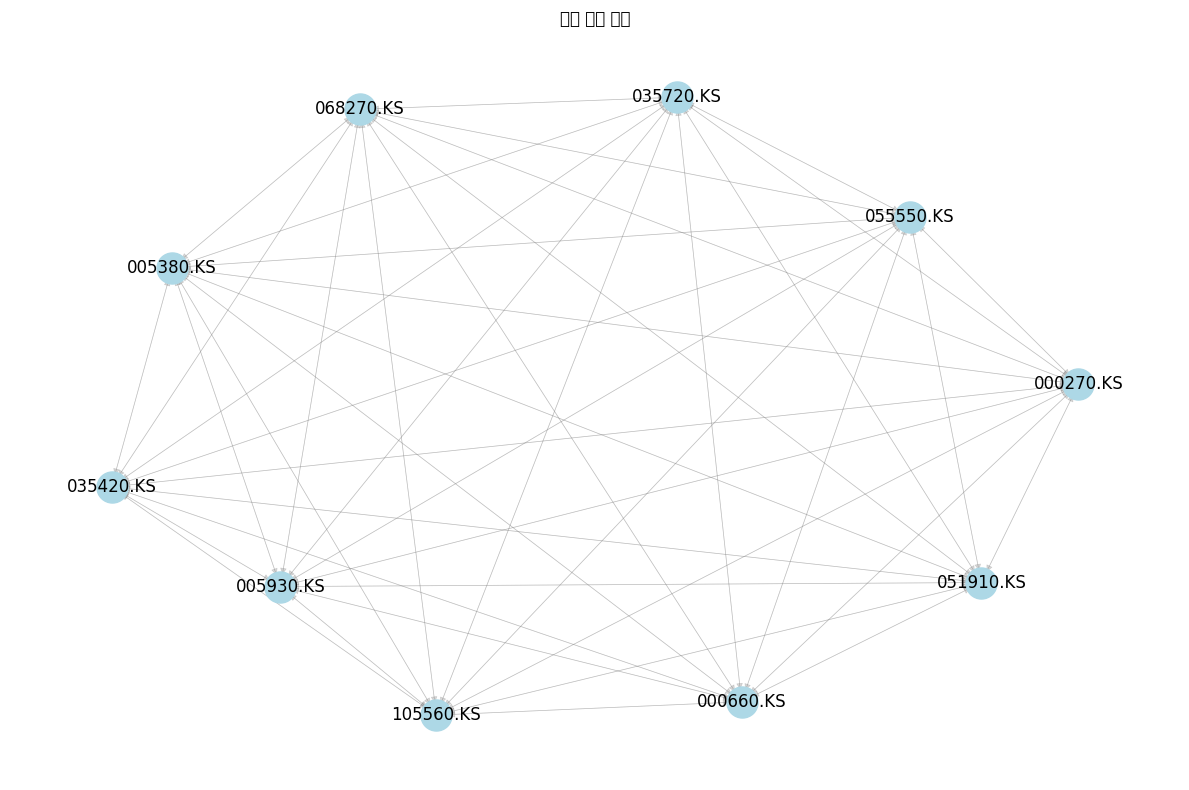


최적 거래 계획:
경로 1: 005930.KS, 비용: 0.0000
경로 2: 000660.KS, 비용: 0.0000
경로 3: 035420.KS, 비용: 0.0000
경로 4: 035720.KS, 비용: 0.0000
경로 5: 005380.KS, 비용: 0.0000
경로 6: 000270.KS, 비용: 0.0000
경로 7: 068270.KS, 비용: 0.0000
경로 8: 105560.KS, 비용: 0.0000
경로 9: 055550.KS, 비용: 0.0000

5. LPPLS 모델로 시장 버블 감지 중...
LPPLS 모델 피팅 중...


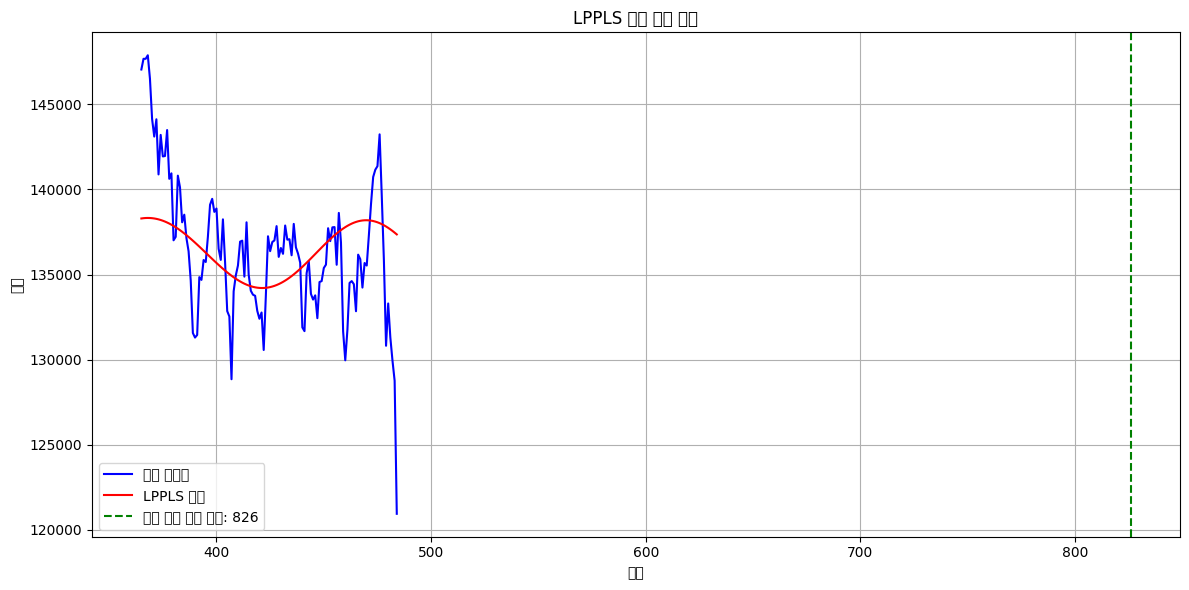


버블 지표: 0.55 - 약한 버블 징후 (주의)
예상 버블 붕괴 시점까지 남은 기간: 342일

최종 리밸런싱 추천 생성 중...

===== 주식 리밸런싱 추천 (2025-04-08) =====

최적 포트폴리오 가중치:
005930.KS: 0.0637 (6.4%)
000660.KS: 0.0618 (6.2%)
035420.KS: 0.0816 (8.2%)
051910.KS: 0.0924 (9.2%)
035720.KS: 0.0625 (6.3%)
005380.KS: 0.1877 (18.8%)
000270.KS: 0.0692 (6.9%)
068270.KS: 0.1364 (13.6%)
105560.KS: 0.1774 (17.7%)
055550.KS: 0.0673 (6.7%)

⚠️ 주의: 약한 버블 징후가 감지되었습니다.
포트폴리오 리스크를 모니터링하고 점진적인 리밸런싱을 고려하세요.

최적 거래 계획:
경로 1: 005930.KS, 비용: 0.0000
경로 2: 000660.KS, 비용: 0.0000
경로 3: 035420.KS, 비용: 0.0000
경로 4: 035720.KS, 비용: 0.0000
경로 5: 005380.KS, 비용: 0.0000
경로 6: 000270.KS, 비용: 0.0000
경로 7: 068270.KS, 비용: 0.0000
경로 8: 105560.KS, 비용: 0.0000
경로 9: 055550.KS, 비용: 0.0000

리밸런싱 요약:
1. 포트폴리오 최적화: GNN 기반 주식 관계 모델링 및 DRL 기반 최적화
2. 거래 비용 최소화: 다익스트라 알고리즘 기반 최적 거래 경로
3. 시장 상황: LPPLS 모델 기반 버블 지표 0.55

모델 실행 완료!


In [ ]:
def main():
    # 테스트용 주식 티커 (한국 주식)
    tickers = ['005930.KS', '000660.KS', '035420.KS', '051910.KS', '035720.KS',
               '005380.KS', '000270.KS', '068270.KS', '105560.KS', '055550.KS']

    # 날짜 설정
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*2)  # 2년 데이터

    # 모델 초기화
    model = StockRebalancingModel(
        tickers=tickers,
        start_date=start_date.strftime('%Y-%m-%d'),
        end_date=end_date.strftime('%Y-%m-%d'),
        risk_aversion=1.0  # 위험 회피 계수 (1.0 = 중립)
    )

    # 데이터 초기화 및 로드
    model.initialize()

    # GNN 모델 학습
    model.train_gnn(epochs=50)

    # DRL 모델 학습
    model.train_drl(num_episodes=50)

    # 최적 거래 경로 찾기
    model.optimize_trading_path()

    # 시장 버블 감지
    model.detect_bubble()

    # 최종 리밸런싱 추천 생성
    recommendation = model.generate_rebalancing_recommendation()

    print("\n모델 실행 완료!")

if __name__ == "__main__":
    main()